# Deep Learning Episode 3: Convolutional Neural Networks

@sunilmallya

@jrhunt

## Load data

We first fetch the [FMNIST](http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/) dataset. 


Each image in this dataset has been resized into 28x28 with grayscale value between 0 and 254. The following codes download and load the images and the according labels into `numpy`.

In [5]:
# copy helper code from: https://github.com/dmlc/mxnet-notebooks/blob/master/python/tutorials/mnist.ipynb

import numpy as np
import os
import urllib
import gzip
import struct

def download_data(url, force_download=True): 
    fname = url.split("/")[-1]
    if force_download or not os.path.exists(fname):
        urllib.urlretrieve(url, fname)
    return fname

def read_data(label_url, image_url):
    with gzip.open(download_data(label_url)) as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        label = np.fromstring(flbl.read(), dtype=np.int8)
    with gzip.open(download_data(image_url), 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        image = np.fromstring(fimg.read(), dtype=np.uint8).reshape(len(label), rows, cols)
    return (label, image)

path='http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/'

(train_lbl, train_img) = read_data(
    path+'train-labels-idx1-ubyte.gz', path+'train-images-idx3-ubyte.gz')
(val_lbl, val_img) = read_data(
    path+'t10k-labels-idx1-ubyte.gz', path+'t10k-images-idx3-ubyte.gz')

### Labels
Each training and test example is assigned to one of the following labels:

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

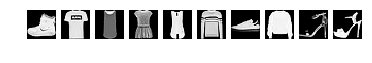

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(train_img[i], cmap='Greys_r')
    plt.axis('off')
    
plt.show()

In [8]:
train_img[0].shape

(28, 28)

In [17]:
# Transform the data

import mxnet as mx

# 4D (batch_size, num_channels, width, height) ==> (bsize, 1, 28, 28)

def to_4d(img):
    return img.reshape(img.shape[0], 1, 28, 28).astype(np.float32)/255

batch_size = 200

train_iter = mx.io.NDArrayIter(to_4d(train_img), train_lbl, batch_size, shuffle=True)
val_iter = mx.io.NDArrayIter(to_4d(val_img), val_lbl, batch_size)

train_iter.__dict__

{'batch_size': 200,
 'cursor': -200,
 'data': [('data', <NDArray 60000x1x28x28 @cpu(0)>)],
 'data_list': [<NDArray 60000x1x28x28 @cpu(0)>, <NDArray 60000 @cpu(0)>],
 'label': [('softmax_label', <NDArray 60000 @cpu(0)>)],
 'last_batch_handle': 'pad',
 'num_data': 60000L,
 'num_source': 2}

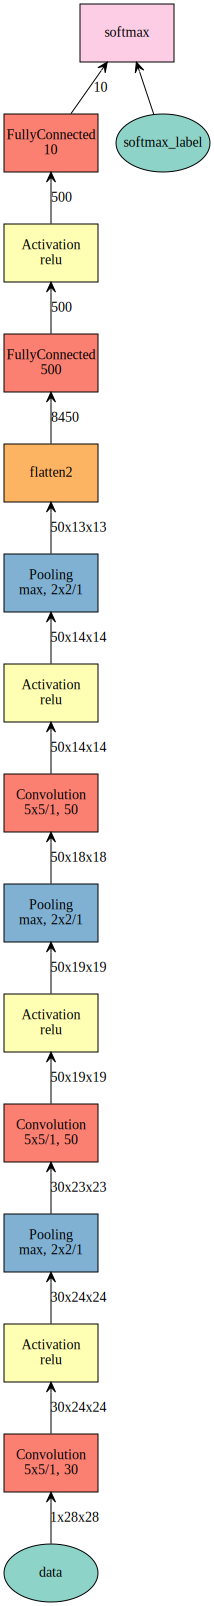

In [30]:
# Model

data = mx.sym.Variable('data')
#mxnet.symbol.Convolution(data=None, weight=None, bias=None, kernel=_Null, stride=_Null, dilate=_Null, pad=_Null, num_filter=_Null, num_group=_Null, workspace=_Null, no_bias=_Null, cudnn_tune=_Null, cudnn_off=_Null, layout=_Null, name=None, attr=None, out=None, **kwargs)¶

# conv 1 layer
conv1 = mx.sym.Convolution(data=data, kernel=(5,5), num_filter=30)
act1 = mx.sym.Activation(data=conv1, act_type='relu')
pool1 = mx.sym.Pooling(data=act1, pool_type="max", kernel=(2,2))

# conv 2 layer
conv2 = mx.sym.Convolution(data=pool1, kernel=(5,5), num_filter=50)
act2 = mx.sym.Activation(data=conv2, act_type='relu')
pool2 = mx.sym.Pooling(data=act2, pool_type="max", kernel=(2,2))

# conv 3 layer
conv3 = mx.sym.Convolution(data=pool2, kernel=(5,5), num_filter=50)
act3 = mx.sym.Activation(data=conv3, act_type='relu')
pool3 = mx.sym.Pooling(data=act3, pool_type="max", kernel=(2,2))


# Fully connected layer
flatten = mx.sym.Flatten(pool3)
fc1 = mx.sym.FullyConnected(data=flatten, num_hidden=500)
act3 = mx.sym.Activation(data=fc1, act_type='relu')

fc2 = mx.sym.FullyConnected(data=act3, num_hidden=10)

lenet = mx.sym.SoftmaxOutput(data=fc2, name="softmax")

# Output layer

shape = {"data": (batch_size, 1, 28, 28)}
mx.viz.plot_network(lenet, shape=shape)

In [31]:
# Train the model

import logging
logging.getLogger().setLevel(logging.DEBUG)

ctx = [mx.gpu(i) for i in range(2)]
num_epoch = 10

net = mx.mod.Module(symbol=lenet, context=ctx)
net.bind(data_shapes=[train_iter.provide_data[0]], label_shapes=[train_iter.provide_label[0]])

net.fit(train_iter,
       val_iter,
       optimizer="sgd",
       optimizer_params={'learning_rate' : 0.1},
       eval_metric='acc',
       batch_end_callback=mx.callback.Speedometer(batch_size, 200),
       num_epoch=num_epoch
       )

INFO:root:Epoch[0] Batch [200]	Speed: 9048.97 samples/sec	Train-accuracy=0.100299
INFO:root:Epoch[0] Train-accuracy=0.097172
INFO:root:Epoch[0] Time cost=6.640
INFO:root:Epoch[0] Validation-accuracy=0.100000
INFO:root:Epoch[1] Batch [200]	Speed: 9177.58 samples/sec	Train-accuracy=0.106294
INFO:root:Epoch[1] Train-accuracy=0.167475
INFO:root:Epoch[1] Time cost=6.534
INFO:root:Epoch[1] Validation-accuracy=0.359800
INFO:root:Epoch[2] Batch [200]	Speed: 9134.87 samples/sec	Train-accuracy=0.332289
INFO:root:Epoch[2] Train-accuracy=0.640758
INFO:root:Epoch[2] Time cost=6.542
INFO:root:Epoch[2] Validation-accuracy=0.606100
INFO:root:Epoch[3] Batch [200]	Speed: 9189.22 samples/sec	Train-accuracy=0.722687
INFO:root:Epoch[3] Train-accuracy=0.758788
INFO:root:Epoch[3] Time cost=6.521
INFO:root:Epoch[3] Validation-accuracy=0.748600
INFO:root:Epoch[4] Batch [200]	Speed: 9182.11 samples/sec	Train-accuracy=0.781667
INFO:root:Epoch[4] Train-accuracy=0.798333
INFO:root:Epoch[4] Time cost=6.512
INFO:roo

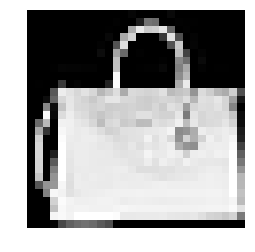

predicted: 8 , probability: 0.930137 


In [32]:

# prediction function

idx = 30; 
plt.imshow(val_img[idx], cmap='Greys_r')
plt.axis('off')
plt.show()

preds = net.predict(val_iter)
prob = preds[idx].asnumpy()

print "predicted: %d , probability: %f " % (prob.argmax(), max(prob))